In [156]:
import numpy as np
from sklearn import svm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import time
import seaborn as sns
sns.set_style("ticks")

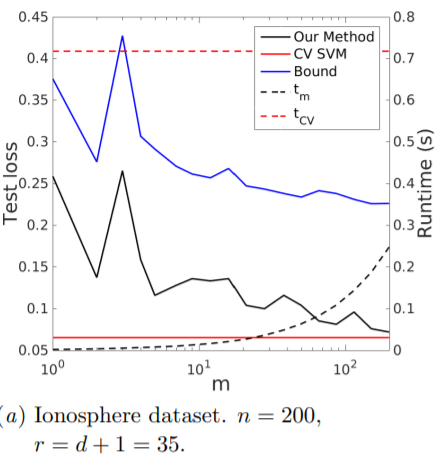

In [81]:
with open("ionosphere.data") as dat:
    dat = np.genfromtxt(dat,delimiter = ",",dtype=str)
    y = dat[:,-1]=='g'
    X = dat[:,:-1].astype(float)
    

X, X_test, y, y_test = train_test_split(X,y, test_size=0.2)

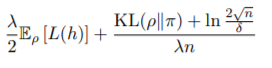

In [125]:
def KL(p,q):
    a = p*np.log(p/q)
    b = (1-p)*np.log((1-p)/(1-q))
    a[p == 0] = 0
    b[p == 1] = 0
#     b[q == 1] = np.inf
    return a + b

def bound(lambd):
    return lambd/2*exp_rho[L] + (KL(rho,1/m) + ln(2*np.sqrt(n)))/(lamdb*n)

Update Rules

rho = 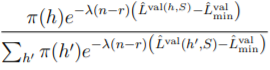
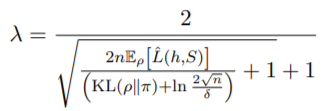

            Doing the experiment

In [157]:
def DoRuns(ms):
    ids = [i for i in range(len(X))]

    r = 35
    n = 200

    Losses = []
    localtimes = []
    for m in ms:
        starttime = time.time()
        samples = np.random.choice(ids,(m,r))

        Ls = []
        models = []
        for s in samples:
            clf = svm.SVC()
            clf.fit(X[s], y[s])
            models.append(clf)
            test = np.random.choice(list(set(ids).difference(s)),n-r)
            pred = clf.predict(X[test])
            Ls.append(np.sum(pred == y[test])/len(pred))

        Ls = np.array(Ls)

        lambds = np.ones(len(Ls))/50
        rhos = np.ones(len(Ls))/50
        delta = 1

        # Find rhos
        for i in range(200):

            # Lambda
            p1 = 2*n*Ls
            p2 = KL(rhos,1/m)
            p3 = np.log(2*np.sqrt(n)/delta)*np.ones(len(Ls))

            lambds = np.nan_to_num(2/(np.sqrt(p1/(p2+p3)+1)+1))

            # rho
            L_val_min = np.min(Ls)
            _sum = np.sum(1/m*np.exp(-lambds*(n-r)*(Ls-L_val_min)))
            rhos = (1/m*np.exp(-lambds*(n-r)*(Ls-L_val_min)))/(_sum)

        # Majority vote:

        scaled_guesses = np.array([model.predict(X_test) for model in models])*2 -1
        guess = np.sign(np.sum(rhos*scaled_guesses.T,axis = 1))

        voted_accuracy = (np.sum((np.array((guess + 1)/2).astype(bool) == y_test))/len(y_test))
        localtimes.append(time.time() - starttime)
        Losses.append(voted_accuracy)
        
    return (Losses, localtimes)


ms = np.unique(np.logspace(0.3,2.54,20).astype(int))


AllResults = []
times = []
for _ in tqdm(range(10)):
    r, t = DoRuns(ms)
    AllResults.append(r)
    times.append(t)

AllResults = np.array(AllResults)
times = np.array(times)


  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\jakob\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\jakob\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\jakob\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\jakob\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\jakob\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel packag

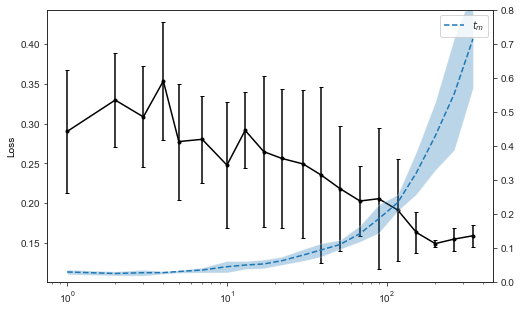

In [177]:
fig,ax1 = plt.subplots(figsize =(8,5))

plotloss = np.mean(AllResults,axis = 0)
yerr = np.std(AllResults,axis = 0)

ax1.errorbar(ms,plotloss-0.5,yerr=yerr,capsize =2,fmt='.',color = "black")
ax1.plot(ms,plotloss-0.5,color = "black")
ax1.set_xscale("log")
ax1.set_ylabel("Loss",color = "black")


ax2 = ax1.twinx()

plottimes = np.mean(times,axis = 0)
yerr = np.std(times,axis = 0)

ax2.fill_between(ms,plottimes+yerr,plottimes-yerr,alpha = 0.3)
ax2.plot(ms,plottimes,'--',label = "$t_m$")
ax2.set_ylim(0,0.8)

plt.legend()
# sns.despine()
plt.show()
